In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

c = 299792458.0
G = 6.67430e-11
M_sun = 1.989e30

In [2]:
# Use M0 = Msun
L0   = G * M_sun / c**2          # [m]
rho0 = c**2 / (G * L0**2)        # [kg/m^3]
p0   = rho0                      # p := P/c^2 has same units as rho (kg/m^3)

In [3]:
Gamma = 1.3569

rho_r_ref = 1e13 * 1000.0              # 1e13 g/cm^3 -> 1e16 kg/m^3

# Convert (P/c^2) from dyn/cm^2 to SI and then to kg/m^3:
P_over_c2_ref = (1.5689e31 * 0.1) / (c**2)   # dyn/cm^2 -> Pa, then /c^2 -> kg/m^3

K_SI  = P_over_c2_ref / (rho_r_ref**Gamma)

# Dimensionless Khat for: p_hat = Khat * rho_r_hat^Gamma
# where p_hat = (P/c^2)/p0 and rho_r_hat = rho_r/rho0
Khat = K_SI * (rho0**Gamma) / p0            # = K_SI * rho0^(Gamma-1)

In [4]:
def eos_from_p(p_hat: float):
    """
    Input:  p_hat = (P/c^2)/p0
    Output: rho_hat = rho/rho0, rho_r_hat = rho_r/rho0
    """
    p_hat = max(float(p_hat), 0.0)
    if p_hat == 0.0:
        return 0.0, 0.0

    rho_r_hat = (p_hat / Khat)**(1.0 / Gamma)
    rho_hat   = rho_r_hat + (Khat / (Gamma - 1.0)) * (rho_r_hat**Gamma)
    return rho_hat, rho_r_hat

In [5]:
def tov_rhs(r, y):
    # y = [m(r), nu(r), p(r)]  all dimensionless
    m, nu, p = y
    rho, rho_r = eos_from_p(p)

    if r <= 0.0:
        return [0.0, 0.0, 0.0]

    denom = r * (r - 2.0*m)

    dm  = 4.0*np.pi * r**2 * rho_r 
    dnu = 2.0 * (m + 4.0*np.pi*r**3*p) / denom
    dp  = - (m + 4.0*np.pi*r**3*p) * (rho + p) / denom

    return [dm, dnu, dp]

def surface_event(r, y):
    return y[2]   # p hits 0

surface_event.terminal  = True
surface_event.direction = -1

In [6]:
def integrate_star_a(pc_hat, r0=1e-6, rmax=50.0):
    rho_c, _ = eos_from_p(pc_hat)

    # regular center expansion
    m0  = (4.0*np.pi/3.0) * rho_c * r0**3
    nu0 = 0.0
    y0  = [m0, nu0, pc_hat]

    sol = solve_ivp(
        tov_rhs, (r0, rmax), y0,
        events=surface_event,
        rtol=1e-8, atol=1e-10,
        max_step=0.05
    )

    if sol.status == 1 and sol.t_events[0].size > 0:
        R_hat = sol.t_events[0][0]
        M_hat = sol.y_events[0][0][0]
        return R_hat, M_hat
    else:
        return np.nan, np.nan

In [7]:
pc_list = np.logspace(-12, -2, 200)

pc_used = []
M_list  = []
R_list_km = []

for pc in pc_list:
    R_hat, M_hat = integrate_star_a(pc)
    if np.isfinite(R_hat):
        pc_used.append(pc)
        M_list.append(M_hat)
        R_list_km.append(R_hat * L0 / 1000.0)

pc_used = np.array(pc_used)
M_list  = np.array(M_list)
R_list_km = np.array(R_list_km)

In [8]:
# numerical derivative
dM_dpc = np.gradient(M_list, pc_used)

stable_mask   = dM_dpc > 0
unstable_mask = dM_dpc < 0

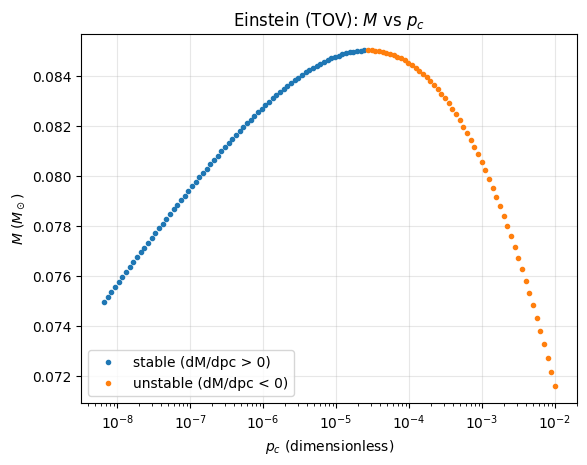

In [9]:
plt.figure()

plt.plot(pc_used[stable_mask],   M_list[stable_mask],   "o", markersize=3, label="stable (dM/dpc > 0)")
plt.plot(pc_used[unstable_mask], M_list[unstable_mask], "o", markersize=3, label="unstable (dM/dpc < 0)")

plt.xscale("log")
plt.xlabel(r"$p_c$ (dimensionless)")
plt.ylabel(r"$M$ ($M_\odot$)")
plt.title(r"Einstein (TOV): $M$ vs $p_c$")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [10]:
i_max = np.argmax(M_list)
print("M_max  =", M_list[i_max], "Msun")
print("pc_at_Mmax =", pc_used[i_max])
print("R_at_Mmax =", R_list_km[i_max], "km")

M_max  = 0.0850137800170341 Msun
pc_at_Mmax = 2.736439997074672e-05
R_at_Mmax = 10.19284192133808 km
